# This is modified after `13_check_anomaly.ipynb`

In [16]:
from tqdm import tqdm
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker

import numpy as np
import os, glob
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=0
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
import argparse, subprocess
from importlib import reload
import cmasher as cmr

In [17]:
mode = 'nh'
iout = 1026
repo, rurmode, dp = mode2repo(mode)
snap = uri.RamsesSnapshot(repo, iout, mode=rurmode)
snaps = uri.TimeSeries(snap)
snaps.read_iout_avail()
nout = snaps.iout_avail['iout']
gals = pklload("./database/01_nh_ghmatch.pickle")
hals = uhmi.HaloMaker.load(snap, galaxy=False, double_precision=dp)

results = pklload(f"./database/03_MWA1s.pickle")
pairs = pklload(f"./database/06_nh_subhalo_pairs.pickle")
scores = pklload(f"./database/08_nh_scores.pickle")
dm_scores = pklload("./database/08_nh_dm_scores.pickle")

cols = [
    "Host", "Sat", "r50m", "r90m", "r50r", "r90r", 
    "SFR_mem", "u_mem", "g_mem", "r_mem", "i_mem", "z_mem", "metal_mem", "ager_mem", "t50_mem", "t90_mem"] 
category = ["r50m", "r90m", "r50r", "r90r", "rmax"]
for icate in category:
    cols = cols+[f"SFR_{icate}", f"u_{icate}", f"g_{icate}", f"r_{icate}", f"i_{icate}", f"z_{icate}", f"metal_{icate}", f"ager_{icate}", f"t50_{icate}", f"t90_{icate}", f"mgas_{icate}", f"mcold_{icate}", f"mdm_{icate}"]
dtype = [(col, np.float64) for col in cols]
print(len(dtype))
dtype[0] = ("Host", np.int32)
dtype[1] = ("Sat", np.int32)
dtype = np.dtype(dtype)
vad = np.genfromtxt("./database/09_value_added.txt", delimiter="\t", dtype=dtype, skip_header=1)
# pklsave(vad, "./database/09_value_added.pickle")

81


In [18]:
# xval = 'z'
# yval = 'y'

# fig, ax = fancy_axis(figsize=(6, 6))
# # ax.scatter(results['x'], results['y'], marker='x', color='w')
# regions = np.zeros(len(results), dtype=[('id',np.int32),('region','<U1')])
# regions['id'] = results['id']
# regions['region'] = 'z'

# init_alphabet()
# text = get_alphabet()
# print(text)
# for result in results:
#     neighbor = cut_sphere(results, result['x'], result['y'], result['z'], result['r200_code']*1.5, both_sphere=True)
#     # print(len(neighbor))
#     if(len(neighbor)>1):
#         already=True
#         for neigh in neighbor:
#             arg = np.where(results['id']==neigh['id'])[0][0]
#             if(regions['region'][arg] != 'z'):
#                 pass
#             else:
#                 regions['region'][arg] = text
#                 already=False
#         if(not already): text = get_alphabet()


# init_colors()
# for text in np.unique(regions['region']):
#     if(text=='z'): continue
#     print(text)
#     groups = regions[regions['region']==text]['id']
#     color = get_color()
#     dy = 0.005
#     for group in groups:
#         target = results[results['id']==group][0]
#         # cir = circle(target, rname='r200_code', color=color)
#         cir = plt.Circle((target[xval], target[yval]), target['r200_code'], color=color, fill=False)
#         ax.add_patch(cir)
#         ax.scatter(target[xval], target[yval], marker='x', color='w')
#         ax.text(target[xval], target[yval]+dy, target['id'], color=color, fontsize=10, ha='center', va='center')
#         dy += 0.005


2) z->b
 > 20) z->b
3) z->c
 > 1252) z->c
4) z->d
 > 19) z->d
 > 91) z->d
7) z->e
 > 1545) z->e
9) z->f
 > 65) z->f
10) z->g
 > 104) z->g
14) z->h
 > 66) z->h
 > 133) z->h
 > 148) z->h
 > 1920) z->h
19) d->d
 > 68) z->d
21) z->i
 > 11) z->i
24) z->j
 > 54) z->j
36) z->k
 > 60) z->k
41) z->l
 > 46) z->l
 > 165) z->l


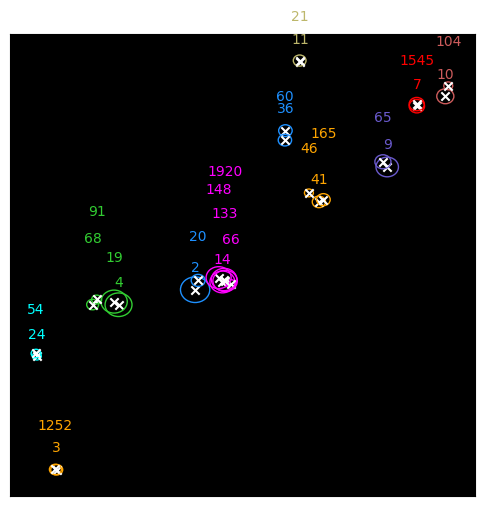

In [19]:
xval = 'z'
yval = 'y'

fig, ax = fancy_axis(figsize=(6, 6))
# ax.scatter(results['x'], results['y'], marker='x', color='w')
regions = np.zeros(len(results), dtype=[('id',np.int32),('region','<U1')])
regions['id'] = results['id']
regions['region'] = 'z'

init_alphabet()
text = get_alphabet()
for i,result in enumerate(results):
    neighbor = cut_sphere(results, result['x'], result['y'], result['z'], result['r200_code']*2, both_sphere=True)
    text = regions[i]['region']
    if(len(neighbor)>1):
        count = 0
        for neigh in neighbor:
            if(neigh['id']==result['id']): continue
            arg = np.where(results['id']==neigh['id'])[0][0]
            if(regions['region'][arg] != 'z'):
                pass
            else:
                if(text=='z'): text = get_alphabet()
                if(count==0):
                    print(f"{result['id']}) {regions['region'][i]}->{text}")
                    regions['region'][i] = text
                    count += 1
                print(f" > {neigh['id']}) {regions['region'][arg]}->{text}")
                regions['region'][arg] = text
                already=False


init_colors()
for text in np.unique(regions['region']):
    if(text=='z'): continue
    groups = regions[regions['region']==text]['id']
    color = get_color()
    dy = 0.005
    for group in groups:
        target = results[results['id']==group][0]
        # cir = circle(target, rname='r200_code', color=color)
        cir = plt.Circle((target[xval], target[yval]), target['r200_code'], color=color, fill=False)
        ax.add_patch(cir)
        ax.scatter(target[xval], target[yval], marker='x', color='w')
        ax.text(target[xval], target[yval]+dy, target['id'], color=color, fontsize=10, ha='center', va='center')
        dy += 0.005


In [34]:
names = np.unique(regions['region'])[:-1]
names

array(['b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l'], dtype='<U1')

b 2


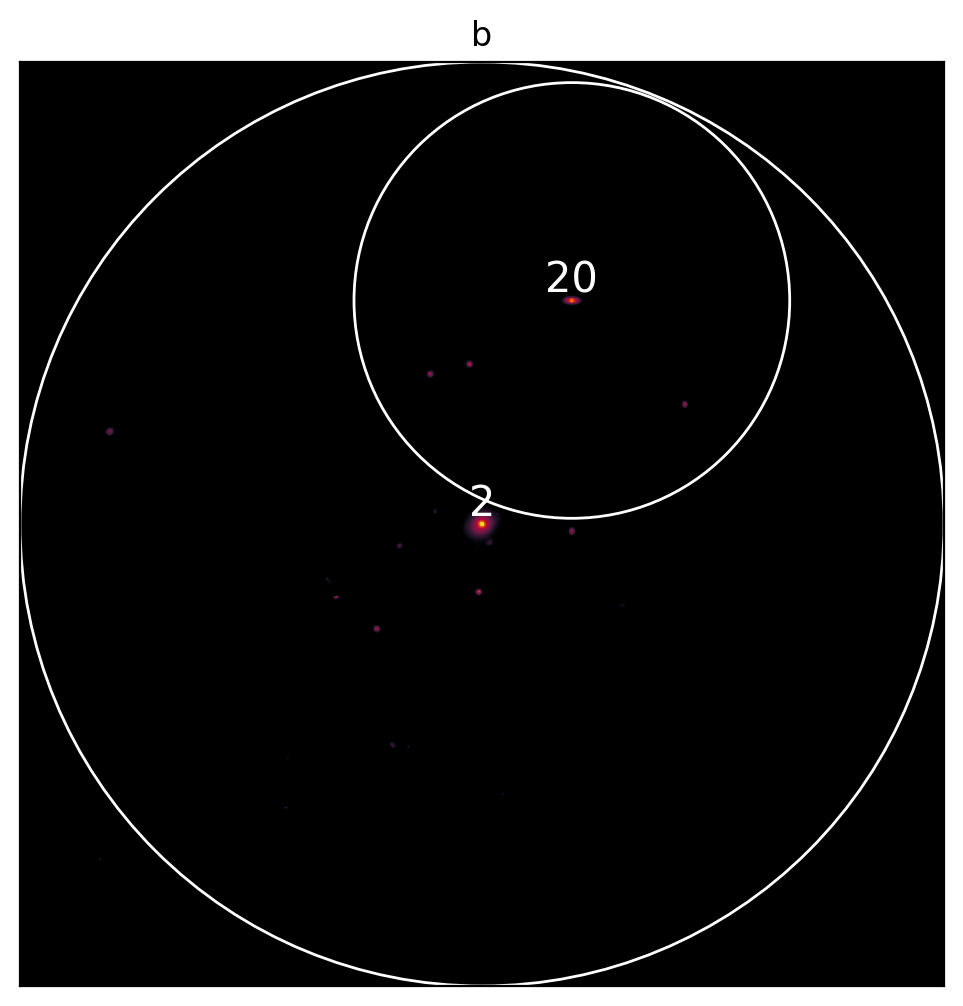

c 2


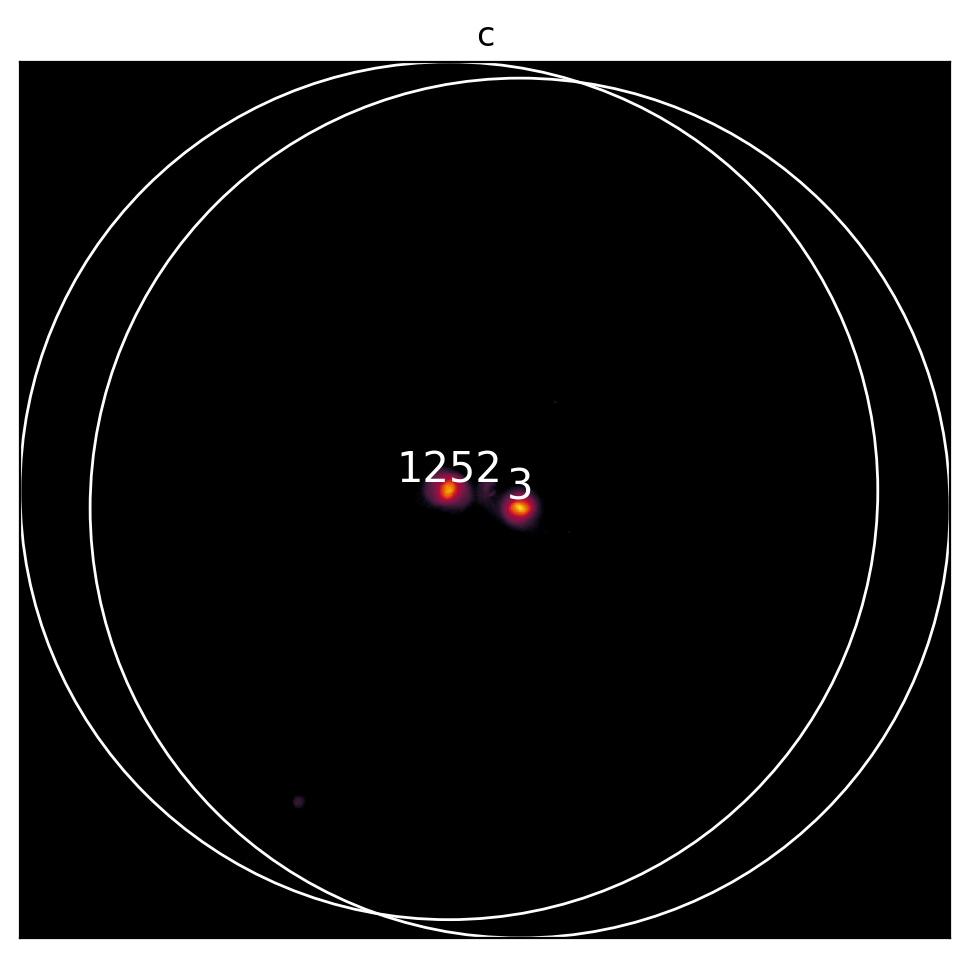

d 4


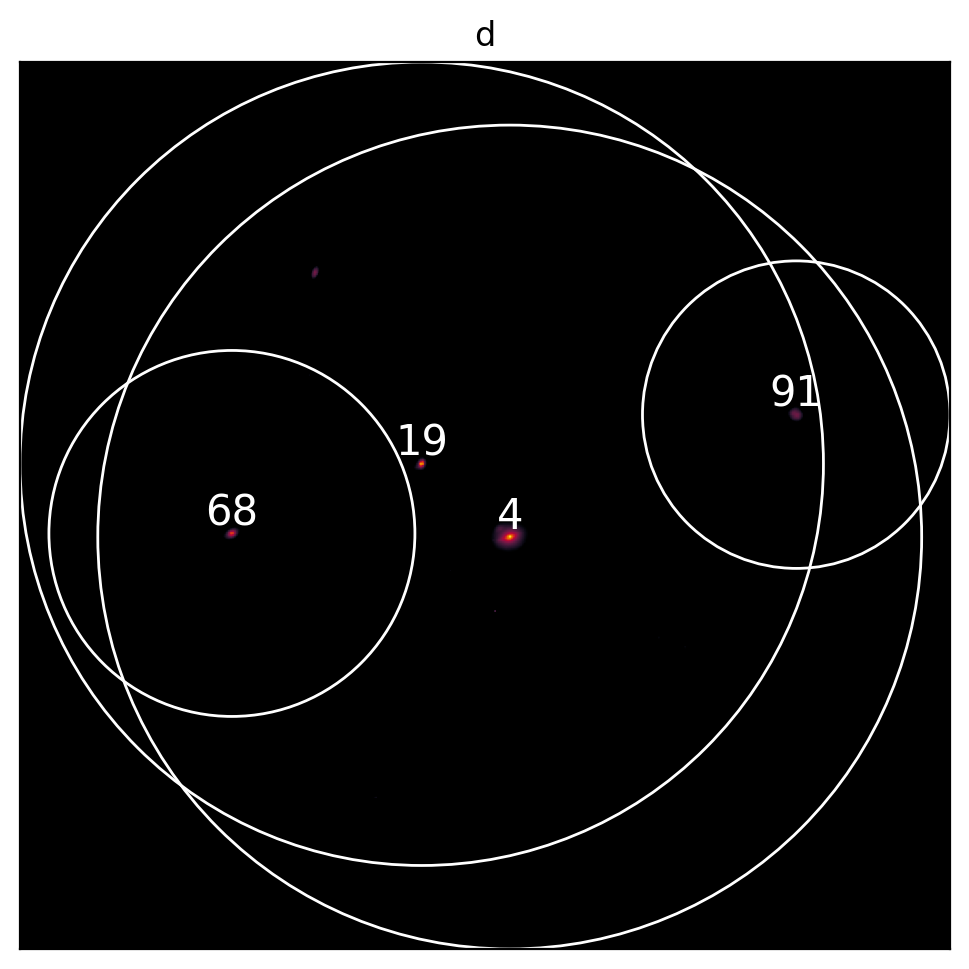

e 2


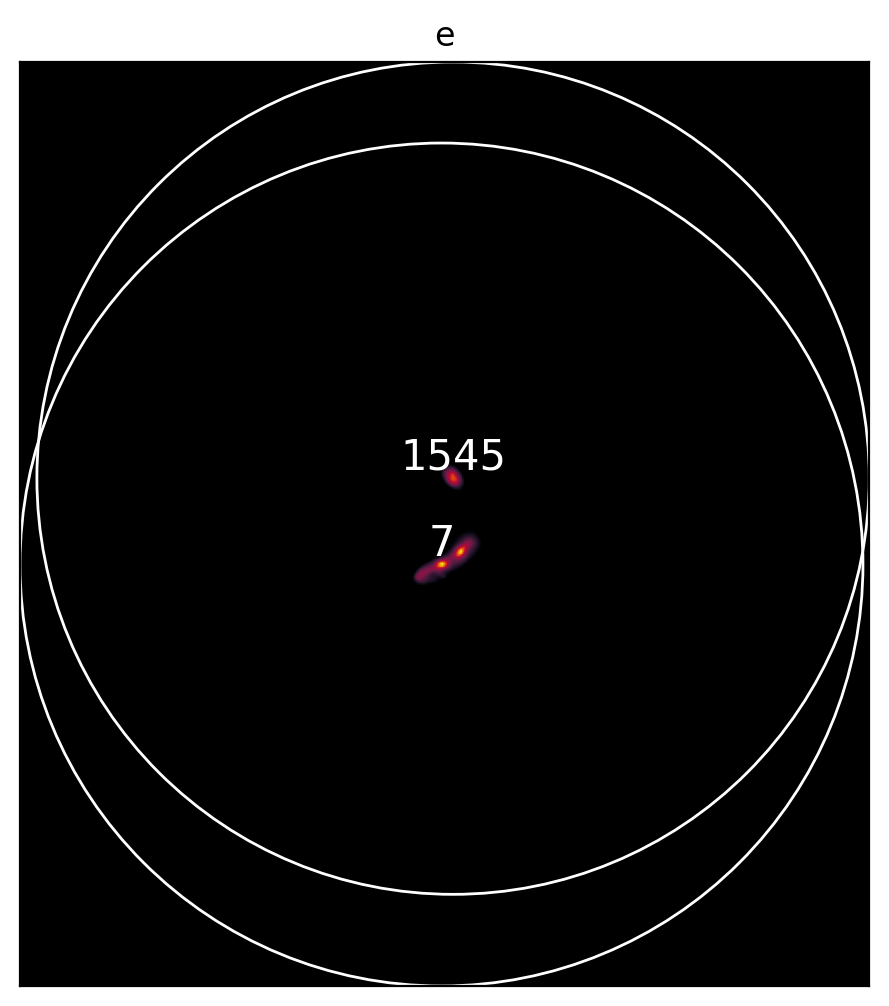

f 2


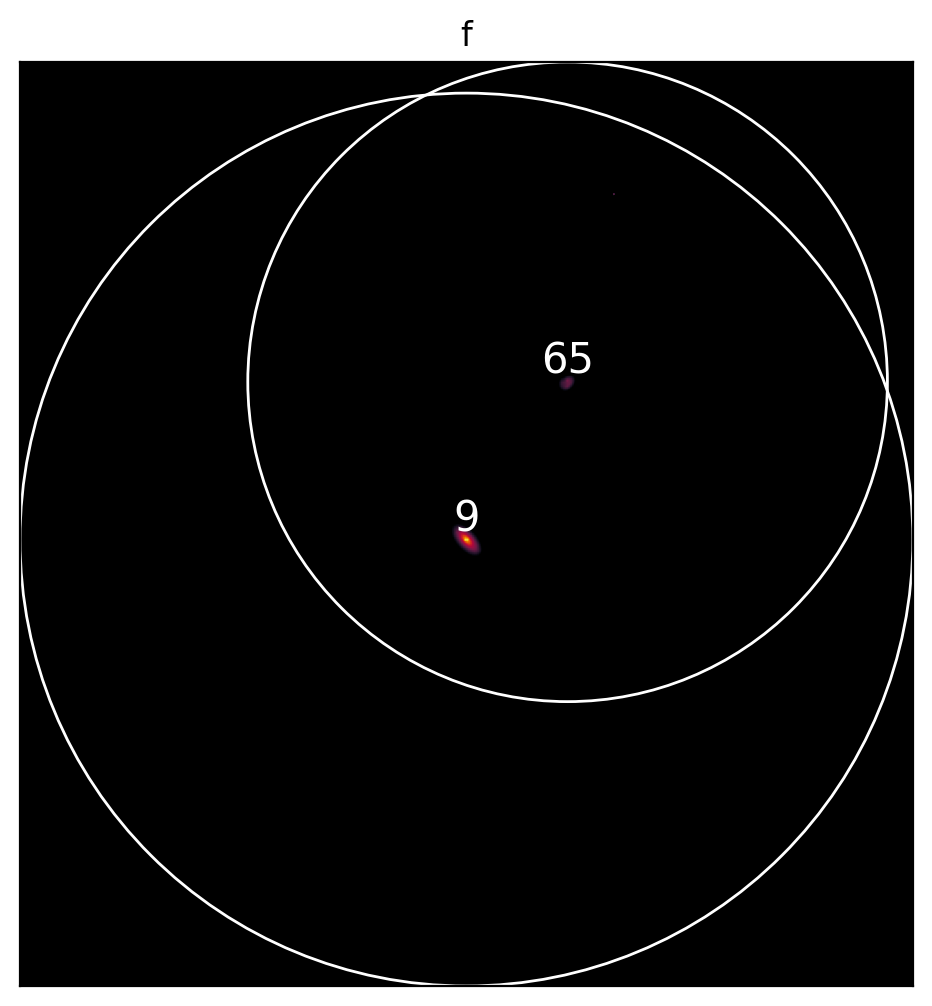

g 2


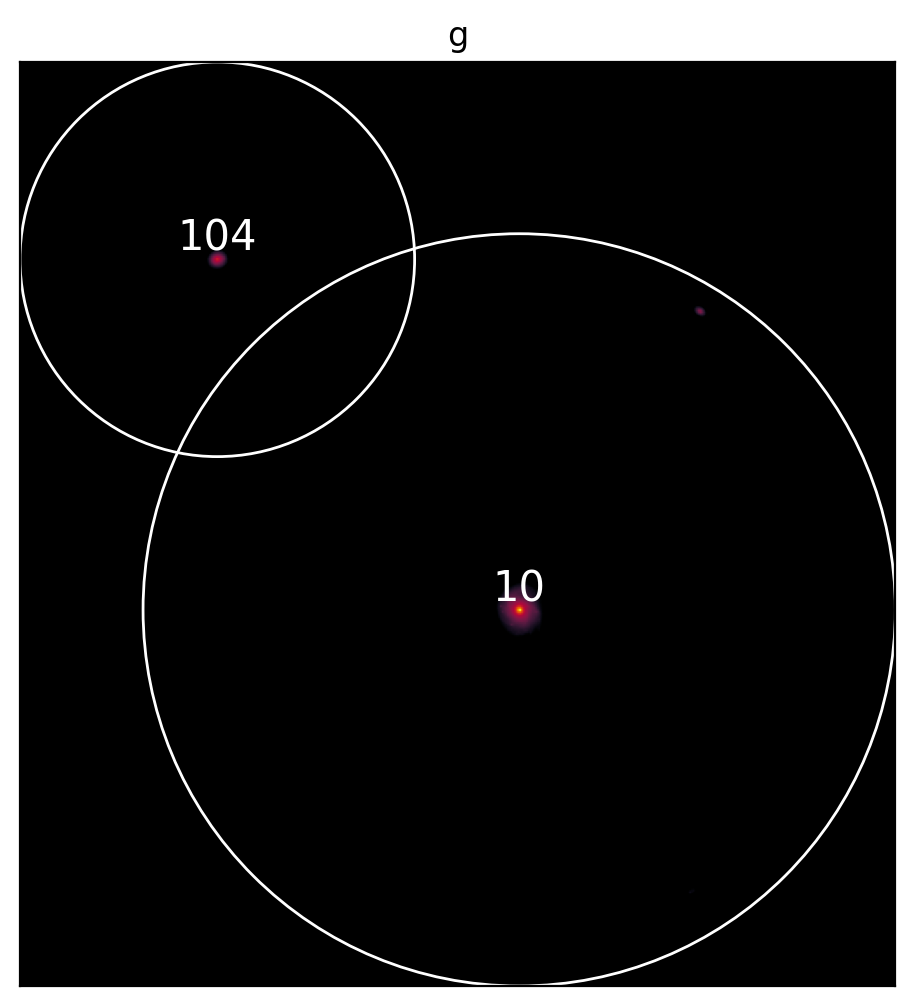

h 5


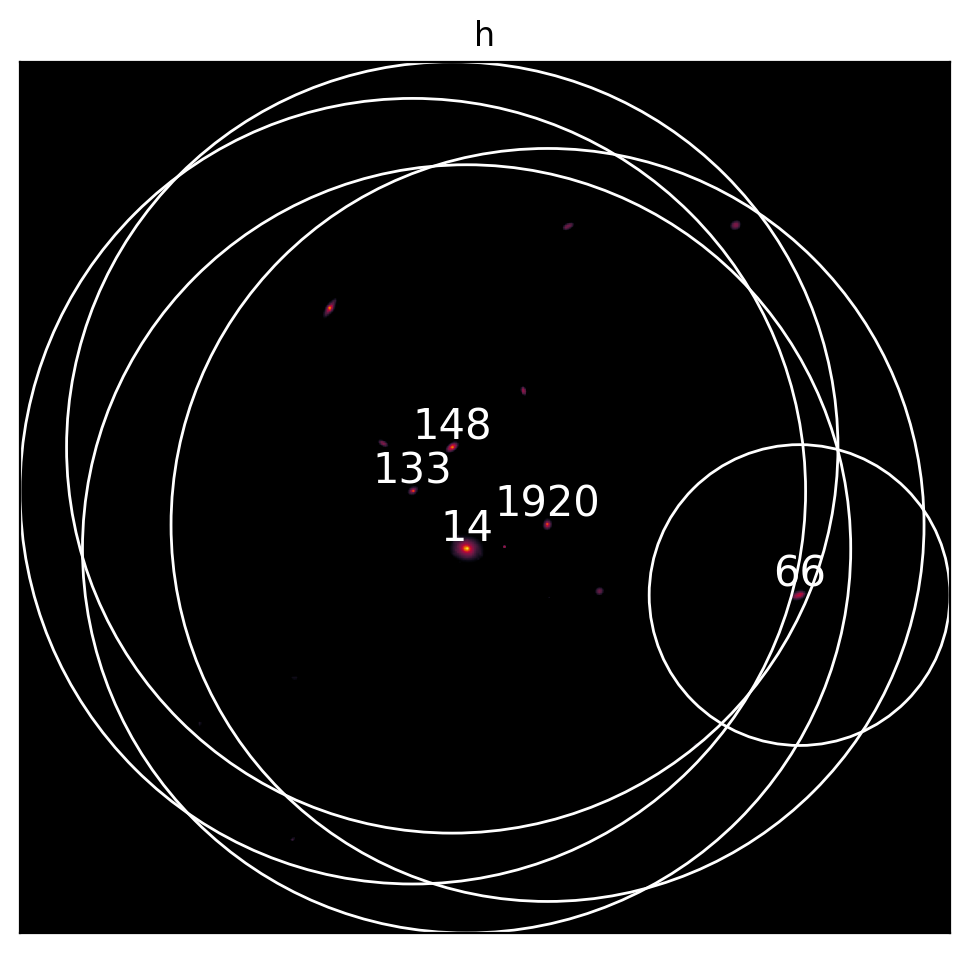

i 2


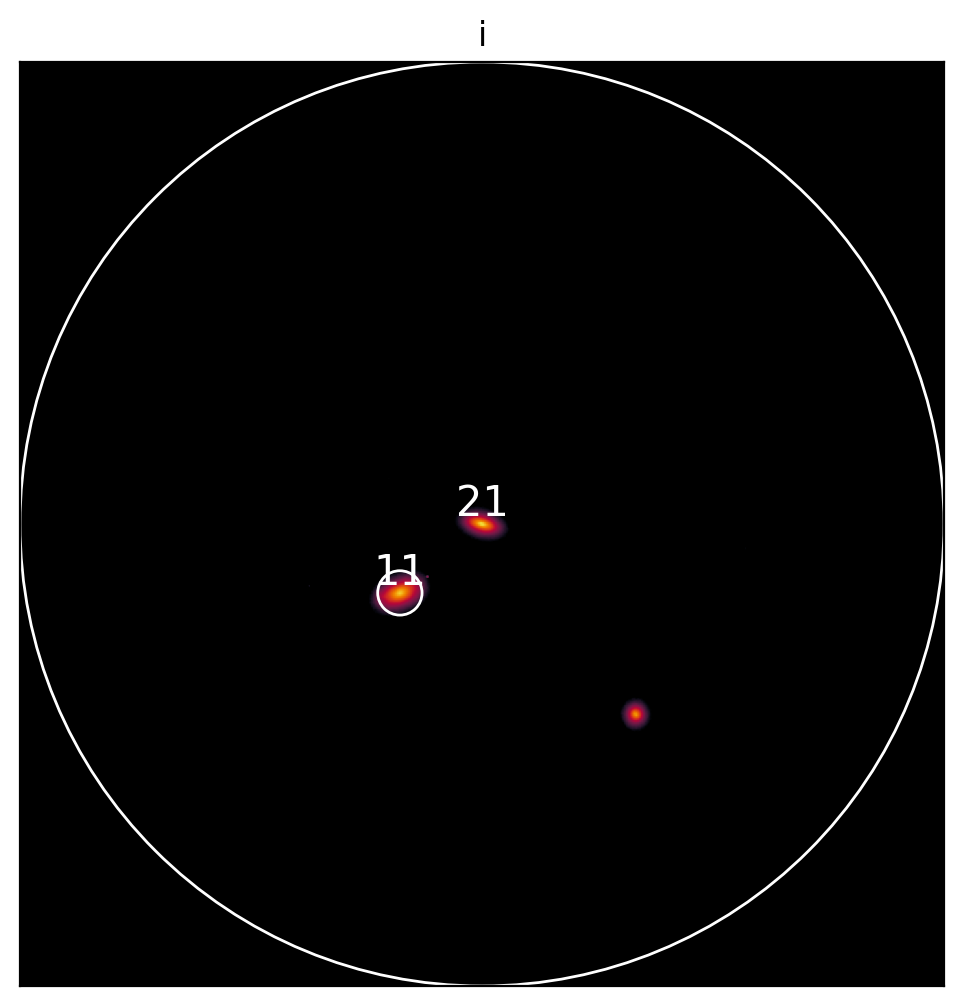

j 2


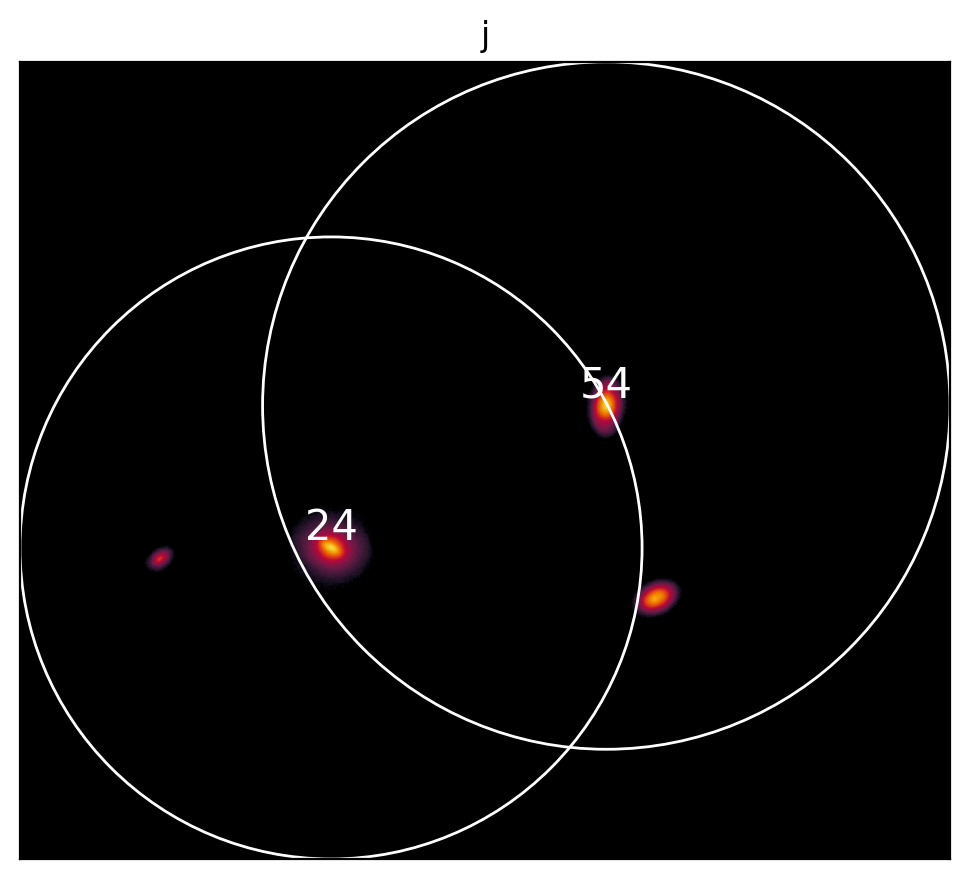

k 2


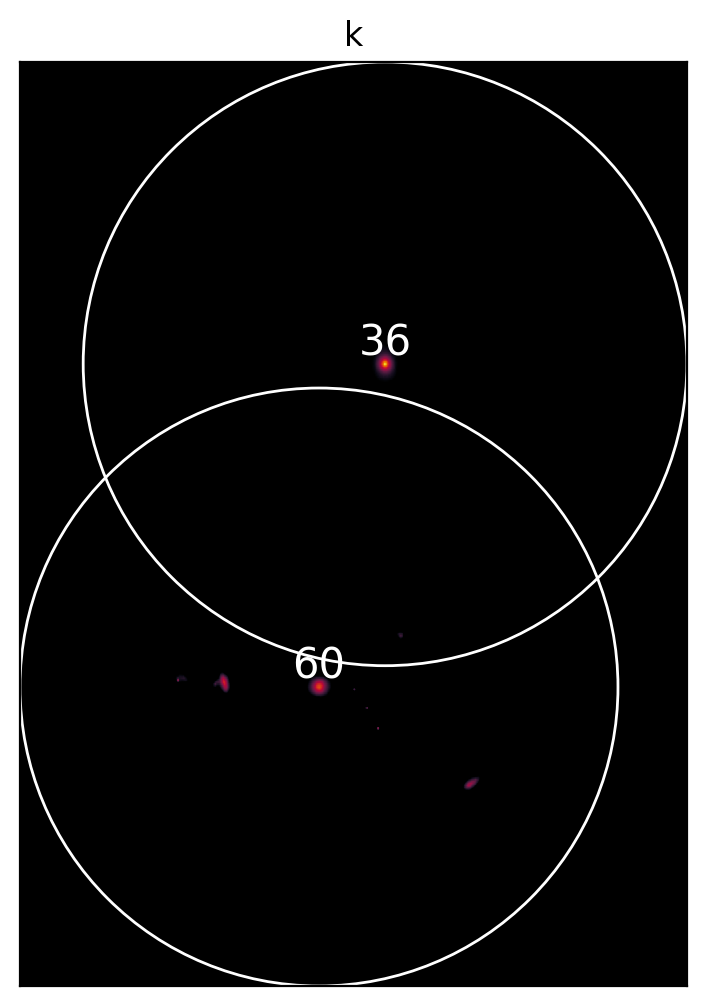

l 3


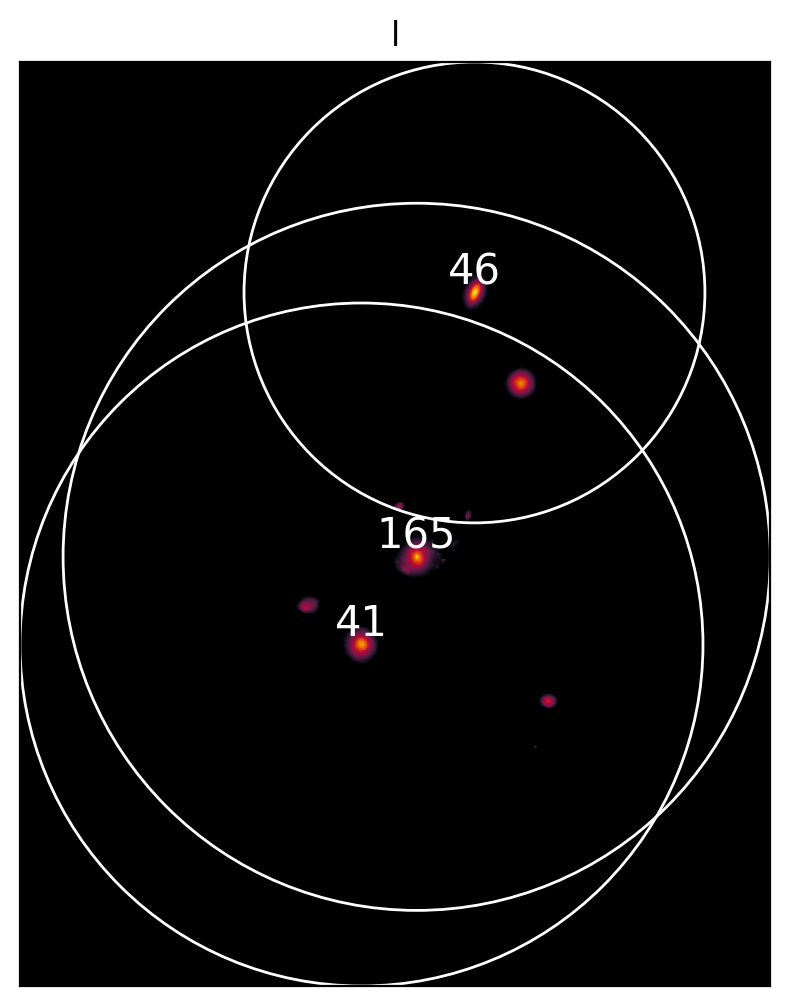

In [35]:
for name in names:
    if(not os.path.exists(f"./database/photo/11_remove_unreal/{name}.png")):
        temp = regions[regions['region']==name]['id']
        ind = isin(results['id'], temp)
        groups = results[ind]
        if(len(groups)<2): continue
        print(name, len(groups))

        x1 = np.min(groups['x'] - groups['r200_code']*1.5)
        x2 = np.max(groups['x'] + groups['r200_code']*1.5)
        y1 = np.min(groups['y'] - groups['r200_code']*1.5)
        y2 = np.max(groups['y'] + groups['r200_code']*1.5)
        z1 = np.min(groups['z'] - groups['r200_code']*1.5)
        z2 = np.max(groups['z'] + groups['r200_code']*1.5)
        snap.box = np.array([[x1, x2], [y1, y2], [z1, z2]])
        snap.get_part(pname='star', nthread=32)
        
        fig, ax = fancy_axis(figsize=(6, 6),dpi=200)
        painter.draw_partmap(snap.part, ax=ax, cmap=cmr.ember)
        for group in groups:
            cir = plt.Circle((group['x'], group['y']), 1.5*group['r200_code'], color='w', fill=False)
            ax.add_patch(cir)
            ax.text(group['x'], group['y'], f"{group['id']}", color='w', fontsize=15, ha='center', va='bottom')
        ax.set_title(name)
        plt.savefig(f"./database/photo/11_remove_unreal/{name}.png", dpi=300, facecolor='white')
        plt.show()
        plt.close()
        snap.clear()

# Basic Array

In [22]:
LocalGroup = {}
for result in results:
    LocalGroup[result['id']] = {}
    LocalGroup[result['id']]['BGG'] = result
    LocalGroup[result['id']]['neighbor'] = np.zeros(0, dtype=[('id',np.int32),('mratio',np.float64)])

## Add merger & neighbor

In [23]:
for name in names:
    temp = regions[regions['region']==name]['id']
    ind = isin(results['id'], temp)
    groups = results[ind]
    temp = [ (ig['id'], np.log10(ig['m'])) for ig in groups ]

    argmax = np.argmax(groups['m'])
    BGG = groups[argmax]
    others = groups[groups['id']!=BGG['id']]
    merger_rate = BGG['m'] / others['m']
    print(f"[{name}] BGG={BGG['id']}")
    for other, mrate in zip(others, merger_rate):
        if(mrate < 4):
            cate = "Major"
        elif(mrate < 10):
            cate = "Minor"
        else:
            cate = "Mini"
        print(f" > {other['id']}) 1:{mrate:.2f} {cate} merger")
        del LocalGroup[other['id']]
        LocalGroup[BGG['id']]['neighbor'] = np.append(LocalGroup[BGG['id']]['neighbor'], np.array([(other['id'], mrate)], dtype=LocalGroup[BGG['id']]['neighbor'].dtype))

[b] BGG=2
 > 20) 1:6.33 Minor merger
[c] BGG=3
 > 1252) 1:1.45 Major merger
[d] BGG=4
 > 19) 1:4.50 Minor merger
 > 68) 1:8.67 Minor merger
 > 91) 1:16.77 Mini merger
[e] BGG=7
 > 1545) 1:3.71 Major merger
[f] BGG=9
 > 65) 1:19.11 Mini merger
[g] BGG=10
 > 104) 1:7.58 Minor merger
[h] BGG=14
 > 66) 1:10.49 Mini merger
 > 133) 1:15.92 Mini merger
 > 148) 1:6.88 Minor merger
 > 1920) 1:13.01 Mini merger
[i] BGG=11
 > 21) 1:1.41 Major merger
[j] BGG=24
 > 54) 1:1.18 Major merger
[k] BGG=36
 > 60) 1:2.11 Major merger
[l] BGG=46
 > 41) 1:1.39 Major merger
 > 165) 1:1.31 Major merger


## Add satellites

In [24]:
keys = list(LocalGroup.keys())
# Find all real sats
for key in keys:
    find_ids = np.array([key])
    if(len(LocalGroup[key]['neighbor'])>0):
        find_ids = np.append(find_ids, LocalGroup[key]['neighbor']['id'])
    
    satids = None
    for find_id in find_ids:
        tmp = np.array(list(scores['take'][find_id].keys()))
        indices = np.zeros(len(tmp), dtype=bool)
        for i, sat in enumerate(tmp):
            scos = scores['take'][find_id][sat]
            indices[i] = (2 * np.median(scos%1)) > 0.5
        tmp = tmp[indices]
        if(len(tmp)>0):
            satids = tmp if(satids is None) else np.union1d(satids, tmp)
    
    if(satids is None):
        LocalGroup[key]['sats'] = np.zeros(0, dtype=vad.dtype)
    else:
        LocalGroup[key]['sats'] = vad[ isin(vad['Sat'], satids) ]

## Add subhalos

In [25]:
keys = list(LocalGroup.keys())
# Find all real subs
for key in keys:
    find_ids = np.array([key])
    if(len(LocalGroup[key]['neighbor'])>0):
        find_ids = np.append(find_ids, LocalGroup[key]['neighbor']['id'])
    
    subids = None
    for find_id in find_ids:
        tmp = np.array(list(dm_scores['take'][find_id].keys()))
        indices = np.zeros(len(tmp), dtype=bool)
        for i, sat in enumerate(tmp):
            scos = dm_scores['take'][find_id][sat]
            indices[i] = (2 * np.median(scos%1)) > 0.5
        tmp = tmp[indices]
        if(len(tmp)>0):
            subids = tmp if(subids is None) else np.union1d(subids, tmp)
    
    if(subids is None):
        LocalGroup[key]['subs'] = np.zeros(0, dtype=hals.dtype)
    else:
        LocalGroup[key]['subs'] = hals[ isin(hals['id'], subids) ]

## Add real pairs

In [26]:
real_members = pklload(f"./database/10_real_members.pickle")
real_members.keys()

dict_keys([1, 2, 3, 4, 7, 8, 9, 10, 14, 17, 19, 20, 21, 23, 24, 25, 26, 29, 35, 36, 37, 40, 41, 46, 47, 52, 54, 60, 63, 64, 65, 66, 68, 75, 84, 91, 92, 104, 107, 108, 121, 129, 133, 136, 148, 165, 168, 207, 212, 937, 1252, 1545, 1920])

In [27]:
keys = list(LocalGroup.keys())
dtype = [('hid',np.int32),('gid',np.int32),('state','<U7')]

for key in keys:
    find_ids = np.array([key])
    if(len(LocalGroup[key]['neighbor'])>0):
        find_ids = np.append(find_ids, LocalGroup[key]['neighbor']['id'])

    real_mems = None
    for find_id in find_ids:
        if(find_id in real_members.keys()):
            tmp = real_members[find_id]
            state = np.zeros(len(tmp), dtype='<U7')
            state[ (tmp[:,0]>0)&(tmp[:,1]>0) ] = 'pair' # pairs
            state[ (tmp[:,0]>0)&(tmp[:,1]==0) ] = 'dink' # DINK
            state[ (tmp[:,0]==0)&(tmp[:,1]>0)] = 'orphan' # Orphans
            empty = np.empty(tmp.shape[0], dtype=dtype)
            empty['hid'] = tmp[:,0]
            empty['gid'] = tmp[:,1]
            empty['state'] = state

        real_mems = empty if(real_mems is None) else np.union1d(real_mems, empty)
    real_mems = np.sort(real_mems, order='gid')
    LocalGroup[key]['real'] = real_mems

## Modify dtype

In [28]:
gals1 = uhmi.HaloMaker.load(snap, galaxy=True, double_precision=dp)
dtype1 = gals1.dtype
gals2 = pklload("./database/01_nh_ghmatch.pickle")
dtype2 = gals2.dtype
dtype3 = LocalGroup[2]['sats'].dtype

names1 = dtype1.names
names2 = dtype2.names
names3 = dtype3.names
print(names1)
print(names2)
print(names3)

('nparts', 'id', 'timestep', 'level', 'host', 'hostsub', 'nbsub', 'nextsub', 'aexp', 'm', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Lx', 'Ly', 'Lz', 'r', 'a', 'b', 'c', 'ek', 'ep', 'et', 'spin', 'sigma', 'sigma_bulge', 'm_bulge', 'rvir', 'mvir', 'tvir', 'cvel', 'rho0', 'rc')
('id', 'timestep', 'nparts', 'level', 'host', 'hostsub', 'aexp', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'm', 'r', 'halo_id', 'halo_nparts', 'halo_level', 'halo_host', 'halo_hostsub', 'halo_x', 'halo_y', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_mvir', 'halo_rvir', 'fcontam', 'dist', 'central', 'main')
('Host', 'Sat', 'r50m', 'r90m', 'r50r', 'r90r', 'SFR_mem', 'u_mem', 'g_mem', 'r_mem', 'i_mem', 'z_mem', 'metal_mem', 'ager_mem', 't50_mem', 't90_mem', 'SFR_r50m', 'u_r50m', 'g_r50m', 'r_r50m', 'i_r50m', 'z_r50m', 'metal_r50m', 'ager_r50m', 't50_r50m', 't90_r50m', 'mgas_r50m', 'mcold_r50m', 'mdm_r50m', 'SFR_r90m', 'u_r90m', 'g_r90m', 'r_r90m', 'i_r90m', 'z_r90m', 'metal_r90m', 'ager_r90m', 't50_r90m', 't90_r90m', 'mgas_r90m',

In [29]:
dtype = dtype1.descr
tmp = [idtype for idtype,iname in zip(dtype2.descr, dtype2.names) if not iname in names1]
dtype = dtype + tmp
tmp = [idtype for idtype,iname in zip(dtype3.descr, dtype3.names) if(not iname in names1)and(not iname in names2)and(iname!='Sat')]
dtype = dtype + tmp
dtype = np.dtype(dtype)

In [30]:
for key in LocalGroup.keys():
    leng = len(LocalGroup[key]['sats'])
    arr = np.zeros(leng, dtype=dtype)
    sat_ids = LocalGroup[key]['sats']['Sat']
    for i, sat_ids in enumerate(sat_ids):
        table1 = gals1[sat_ids-1]
        table2 = gals2[sat_ids-1]
        for iname in dtype.names:
            if iname in names1:
                arr[i][iname] = table1[iname]
            elif iname in names2:
                arr[i][iname] = table2[iname]
            elif iname in names3:
                arr[i][iname] = LocalGroup[key]['sats'][iname][i]
    arr = np.sort(arr, order='id')
    arr = arr[arr['id'] != key]
    LocalGroup[key]['sats'] = arr

In [31]:
LocalGroup[937]['sats']

array([],
      dtype=[('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('sigma_bulge', '<f8'), ('m_bulge', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('halo_id', '<i4'), ('halo_nparts', '<i4'), ('halo_level', '<i4'), ('halo_host', '<i4'), ('halo_hostsub', '<i4'), ('halo_x', '<f8'), ('halo_y', '<f8'), ('halo_z', '<f8'), ('halo_vx', '<f8'), ('halo_vy', '<f8'), ('halo_vz', '<f8'), ('halo_mvir', '<f8'), ('halo_rvir', '<f8'), ('fcontam', '<f8'), ('dist', '<f8'), ('central', '?'), ('main', '?'), ('Host', '<i4'), ('r50m', '<f8'), ('r90m'

In [32]:
pklsave(LocalGroup, f"./database/11_LocalGroup.pickle", overwrite=True)

In [33]:
# 20 -> 2 merging
# 1252 -> 3 merging
# 19 -> 4 merging
# 1545 -> 7 merging
# 65 -> 9 merging
# 133,148,1920 -> 14 merging
# 21 -> 11 merging
# 24 -> 54 merging
# 60 -> 36 merging
# 41 -> 165 merging
